# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

Requirements if running on Google Collab:

In [46]:
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !pip install gym[classic_control]
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1

# Uncomment on Google Colab

Requirements if running locally:

absl-py==1.4.0
asttokens==2.2.1
astunparse==1.6.3
backcall==0.2.0
cachetools==5.3.0
certifi==2022.12.7
charset-normalizer==3.1.0
cloudpickle==2.2.1
colorama==0.4.6
comm==0.1.2
contourpy==1.0.7
cycler==0.11.0
debugpy==1.6.6
decorator==4.4.2
executing==1.2.0
flatbuffers==23.3.3
fonttools==4.39.0
gast==0.4.0
google-auth==2.16.2
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.51.3
gym==0.25.2
gym-notices==0.0.8
h5py==3.8.0
idna==3.4
imageio==2.26.0
imageio-ffmpeg==0.4.8
ipykernel==6.21.3
ipython==8.11.0
jax==0.4.6
jedi==0.18.2
jupyter_client==8.0.3
jupyter_core==5.2.0
keras==2.12.0rc1
kiwisolver==1.4.4
libclang==15.0.6.1
Markdown==3.4.1
MarkupSafe==2.1.2
matplotlib==3.7.1
matplotlib-inline==0.1.6
moviepy==1.0.3
nest-asyncio==1.5.6
numpy==1.23.5
oauthlib==3.2.2
opt-einsum==3.3.0
packaging==23.0
parso==0.8.3
pickleshare==0.7.5
Pillow==9.4.0
platformdirs==3.1.1
proglog==0.1.10
prompt-toolkit==3.0.38
protobuf==4.22.1
psutil==5.9.4
pure-eval==0.2.2
pyasn1==0.4.8
pyasn1-modules==0.2.8
pygame==2.2.0
Pygments==2.14.0
PyOpenGL==3.1.6
pyparsing==3.0.9
python-dateutil==2.8.2
PyVirtualDisplay==3.0
pywin32==305
pyzmq==25.0.0
requests==2.28.2
requests-oauthlib==1.3.1
rsa==4.9
scipy==1.10.1
six==1.16.0
stack-data==0.6.2
tensorboard==2.12.0
tensorboard-data-server==0.7.0
tensorboard-plugin-wit==1.8.1
tensorflow==2.12.0rc1
tensorflow-estimator==2.12.0rc0
tensorflow-intel==2.12.0rc1
tensorflow-io-gcs-filesystem==0.31.0
termcolor==2.2.0
tornado==6.2
tqdm==4.65.0
traitlets==5.9.0
typing_extensions==4.5.0
urllib3==1.26.15
wcwidth==0.2.6
Werkzeug==2.2.3
wrapt==1.14.1

## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

c:\Users\Sean\Documents\GitHub\SC3000-Artificial-Intelligence-Lab-1\venv\Lib\site-packages\tensorflow\python\debug\cli\debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


## Tutorial: Loading CartPole environment

In [4]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02912761  0.01079769 -0.02170693  0.01006483]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [8]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.02891166 -0.18400633 -0.02150564  0.29582068]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an

action regardless of the observation:

In [10]:
from collections import defaultdict
import time, sys

In [11]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

Our RL agent based on ( )





In [12]:
def rl_agent(observation):
    if observation[2] < 0:
        return 0
    elif observation[2] > 0:
        return 1
    else:
        return (random.randint(0,1))

In [13]:
def plot_policy(rewards, title="Equiprobable Policy"):
    plt.plot(rewards)
    plt.xlabel("Episode #")
    plt.ylabel("Expected Reward")
    plt.title(title)
    plt.show()

In [14]:
class Agent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        print("Action size:", self.action_size)

    def get_action_equiprobable(self, Q_s=None, epsilon=None):
        '''
        Generates equiprobable random policy given the action size for the cartpole
        '''
        action = np.random.choice(range(self.action_size))
        return action

    def get_action_momentum(self, state):
        cart_position, cart_velocity, pole_angle, pole_velocity = state
        action = 1 if pole_angle > 0 else 0
        return action
    
    def parse_state(self, state, pprint=False):
        cart_position, cart_velocity, pole_angle, pole_velocity = state
        if pprint:
            print("Cart Position:", cart_position, "\nCart Velocity:", cart_velocity, "\nPole Angle:", pole_angle, "\nPole Velocity:", pole_velocity)
        return cart_position, cart_velocity, pole_angle, pole_velocity

agent = Agent(env)
state = env.reset()
print("Initial State\n")
_ = agent.parse_state(state, True)

Action size: 2
Initial State

Cart Position: 0.035694648 
Cart Velocity: -0.04928711 
Pole Angle: -0.04606155 
Pole Velocity: 0.04893599


### Implement Discretization (coverting a continuous state space into a discrete state space):

Lower bound of observational space:

In [15]:
print(env.observation_space.low)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [16]:
print(env.observation_space.high)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [17]:
set_lower_bounds = np.array([-2.35, -5, -0.22, -5])
set_upper_bounds = np.array([2.35, 5, 0.22, 5])
bin_number = 10 # Sets the number of bins for discretization

In [18]:
def get_width(low, high, number_bins=10):
    '''
    Returns the width of each bin given the lower and upper bounds.
    '''
    return (high - low) / number_bins

In [19]:
def bin_boundary_mean(observation, lower_bound, upper_bound, bin_number):
    '''
    Returns the index number (0 based) given an observation from one state.
    Params:
        observation: the observation vlaue of the state
        lower_bound: lower bound for that observation
        upper_bound: upper bound for that observation
        bin_number: numbert of bins to set index for

    Returns the index number for the specific observation under a state
    '''
    width = get_width(lower_bound, upper_bound, bin_number) # calculates the width for observation
    state_index = -1 # default state index

    if max(lower_bound, observation) == lower_bound: # case when observation <= lower bound
        state_index = 0
    elif min(upper_bound, observation) == upper_bound: # case when observation >= upper_bound
        state_index = bin_number - 1
    else: # case when lower_bound <= observation <= upper_bound
        for i in range(bin_number):
            l = lower_bound + i * width
            delta = abs(l - observation)
            if delta <= width:
                h = lower_bound + (i + 1) * width
                avg = (h + 1) / 2
                if observation >= avg and i < bin_number - 1:
                    state_index = i + 1
                else:
                    state_index = i
                break

    return state_index


In [20]:
def discretize_state(state, bounds, bin_numbers):
    '''
    Generates a set of discretized bin indicies for a set of observations in one state
    Params:
        state: tuple of observations
        bounds: tuple of upper and lower bounds
        bin_number: number of bins
    Returns: (np.array) list of indices for the state
    '''

    lower_bound, upper_bound = bounds
    discretized_observations = []

    for i, obs in enumerate(state):
        index = bin_boundary_mean(obs, lower_bound[i], upper_bound[i], bin_numbers[i])
        discretized_observations.append(index)
    return np.array(discretized_observations)

### Monte Carlo Control policy generation

In [21]:
def generate_episode_Q(env, Q_table, policy, epsilon, bins=[40, 50, 100, 10], render = False):
    '''
    Uses MC control situation.
    Args:
        env: the environment specified by the agent.
        policy: type of policy, pi
        bins: bin numbers for cart position, cart velocity, pole angle, pole velocity
        render: boolean indicating
    '''
    episode = []
    state = env.reset()
    total_reward:float = 0
    
    while True:
        state = discretize_state(state, (set_lower_bounds, set_upper_bounds), bins)
        action = policy(Q_table, state, epsilon) # policy can be greedy or random
        next_state, reward, done,_ = env.step(action)
        total_reward += reward

        episode.append((state, action, reward))
        state = next_state

        env.render() if render else None
        if (done):
            break

    return np.array(episode), total_reward, len(episode)

In [22]:
def policy_Q(Q, state, epsilon):
    '''
    Obtains action probabilities corresponding to epsilon-greedy policy
    '''
    state = tuple(state)
    if state in Q:
        action = np.random.choice(np.arange(agent.action_size), p=get_probs(Q[state], epsilon, agent.action_size))
    else:
        action = env.action_space.sample()
    return action

In [23]:
def get_probs(Q_s, epsilon, nA):
    '''
    Obtains the action probabilities corresponding to episolon-greedy policy
    '''
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [24]:
def update_Q(env, episode, Q, alpha, gamma):
    '''
    Updates the action-value function estimate using the most recent episode
    '''
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[tuple(state)][(actions[i])]
        Q[tuple(state)][actions[i]] = old_Q + alpha * (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [25]:
def mc_control(env, num_episodes, policy, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    '''
    Generalize policy function, pi, using e-greedy policy method
    '''

    action_size = agent.action_size
    Q = defaultdict(lambda: np.zeros(action_size))
    epsilon = eps_start

    for i in range(num_episodes):
        if (i % 100 == 0):
            print(f"\rEpisode {i}/{num_episodes}", end="")
            sys.stdout.flush()

        epsilon = max(epsilon*eps_decay, eps_min)
        episode,_,_ = generate_episode_Q(env, Q, policy, epsilon)
        Q = update_Q(env, episode, Q, alpha, gamma)

    policy = dict((k, np.argmax(v)) for k ,v in Q.items())
    return policy, Q

In [26]:
policy, Q = mc_control(env, 100000, policy_Q, 0.03)

Episode 0/100000

C:\Users\Sean\AppData\Local\Temp\ipykernel_30932\1057904784.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(episode), total_reward, len(episode)


Episode 99900/100000

In [27]:
states, actions = list(policy.keys()), list(policy.values())

In [28]:
len(states)

103840

In [29]:
len(actions)

103840

In [30]:
num_episode = 100
epsilon = np.arange(0.0, 0.5, 0.01)
episodal_eps_val = []
for ep in epsilon:
    total_reward = 0
    for i in range(num_episode):
        _, reward, _ = generate_episode_Q(env, Q, policy_Q, ep)
        total_reward += (reward)/num_episode
    episodal_eps_val.append(total_reward)
episodal_eps_val = np.array(episodal_eps_val)

C:\Users\Sean\AppData\Local\Temp\ipykernel_30932\1057904784.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(episode), total_reward, len(episode)


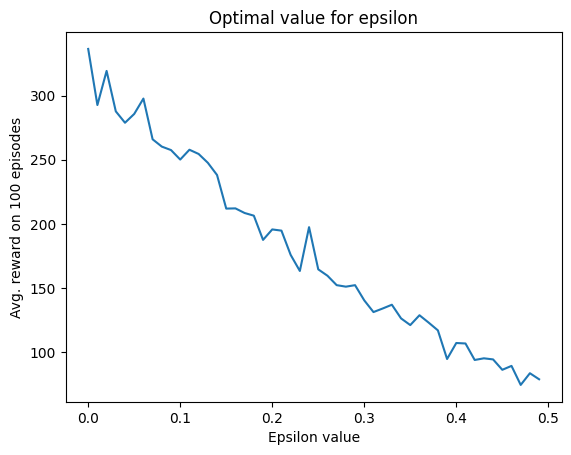

In [31]:
plt.plot(epsilon, episodal_eps_val)
plt.xlabel("Epsilon value")
plt.ylabel("Avg. reward on 100 episodes")
plt.title("Optimal value for epsilon")
plt.show()

In [32]:
episodal_eps_val.max(), episodal_eps_val.argmax()

(336.31000000000006, 0)

In [33]:
optimal_epsilon = epsilon[episodal_eps_val.argmax()]

In [34]:
print("Optimal value for epsilon:", optimal_epsilon)

Optimal value for epsilon: 0.0


In [35]:
len(actions)

103840

In [36]:
optimal_reward = 0
len_iter = 10
for i in range(len_iter):
    episode, reward, ni = generate_episode_Q(env, Q, policy_Q, optimal_epsilon, render=False)
    optimal_reward += reward/len_iter
    time.sleep(0.15)
print(f"Average reward with optimal policy, epsilon={optimal_epsilon} with {len_iter} iterations: {optimal_reward}")

C:\Users\Sean\AppData\Local\Temp\ipykernel_30932\1057904784.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(episode), total_reward, len(episode)


Average reward with optimal policy, epsilon=0.0 with 10 iterations: 370.5


For Task 1, we can show the observation and chosen action below:

In [37]:
def generate_one_round(state, policy, Q_table, epsilon, bins=[40, 50, 100, 10]):
    state = discretize_state(state, (set_lower_bounds, set_upper_bounds), bins)
    action = policy(Q_table, state, epsilon) # policy can be greedy or random
    return action



In [38]:
observation = env.reset()

# action = rand_policy_agent(observation)
# action = rl_agent(observation)
# action = generate_episode_Q()
action = generate_one_round(observation, policy_Q, Q, optimal_epsilon)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.01054194 -0.01739318 -0.00932644  0.03655412]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [39]:
def generate_one_episode():
    cumulative_reward = 0
    done = False
    observation = env.reset()
    while not done:
        observation, reward, done, info = env.step(generate_one_round(observation, policy_Q, Q, optimal_epsilon))
        cumulative_reward += reward

    # print("Cumulative reward for this round:", cumulative_reward)
    return cumulative_reward

print("Cumulative reward for this round:", generate_one_episode())

Cumulative reward for this round: 447.0


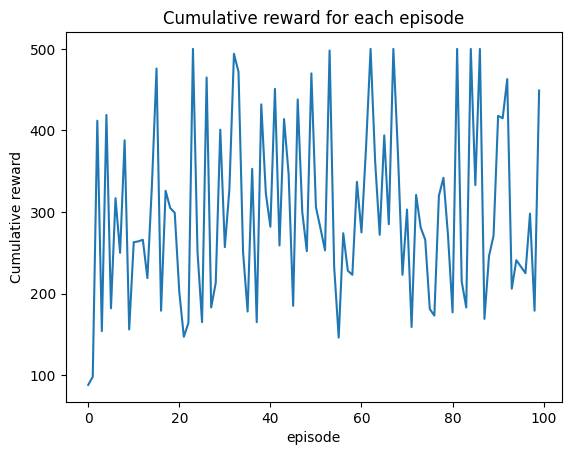

In [40]:
# episode_results = np.random.randint(150, 250, size=100)
episode_results = []

for i in range(0, 100):
    episode_results.append(generate_one_episode())

episode_results = np.array(episode_results)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [41]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 299.16
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [45]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
done = False
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    
    action = generate_one_round(observation, policy_Q, Q, optimal_epsilon)

    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()